# Question about data what is the problem !!
- Give insight to customer success team and recommended from churn activity from customer
- give insight to product team and recommended next decision

# Import all Library

install y-data-profiling for quick EDA information

In [ ]:
!pip install ydata-profiling
!pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler

import scipy.stats as stats
from scipy.stats import skew , kurtosis

from ydata_profiling import ProfileReport

#util
from datetime import datetime
import dateparser # for change datetime data with format ex:01-Jan-2019

# Function

## Analyst H0 vs H1

In [ ]:
def chi_square_test(df, col1, col2):
    """
    Chi-square test untuk menguji hubungan antara dua variabel kategorikal.
    """
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi2 Statistic: {chi2:.4f}")
    print(f"P-Value: {p:.4f}")
    if p < 0.05:
        print("Tolak H0: Ada hubungan antara", col1, "dan", col2)
    else:
        print("Gagal tolak H0: Tidak ada hubungan antara", col1, "dan", col2)

def t_test_independent(df, col_numeric, col_group):
    """
    Independent T-Test untuk menguji perbedaan rata-rata dua grup.
    Contoh A dan B
    """
    unique_groups = df[col_group].dropna().unique()
    if len(unique_groups) != 2:
        raise ValueError("Kolom grup harus memiliki tepat 2 kategori untuk t-test.")
    group1 = df[df[col_group] == unique_groups[0]][col_numeric].dropna()
    group2 = df[df[col_group] == unique_groups[1]][col_numeric].dropna()
    t_stat, p_val = stats.ttest_ind(group1, group2)
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"Tolak H0: Ada perbedaan rata-rata {col_numeric} antara {unique_groups[0]} dan {unique_groups[1]}")
    else:
        print(f"Gagal tolak H0: Tidak ada perbedaan rata-rata {col_numeric} antara {unique_groups[0]} dan {unique_groups[1]}")

def anova_test(df, col_numeric, col_group):
    """
    ANOVA Test untuk menguji perbedaan rata-rata lebih dari dua grup.
    contoh A B C
    """
    unique_groups = df[col_group].dropna().unique()
    if len(unique_groups) < 3:
        raise ValueError("Gunakan t-test jika hanya ada 2 kategori.")
    groups_data = [df[df[col_group] == g][col_numeric].dropna() for g in unique_groups]
    f_stat, p_val = stats.f_oneway(*groups_data)
    print(f"F-Statistic: {f_stat:.4f}")
    print(f"P-Value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"Tolak H0: Setidaknya satu grup dalam {col_group} memiliki rata-rata {col_numeric} yang berbeda")
    else:
        print(f"Gagal tolak H0: Tidak ada perbedaan signifikan rata-rata {col_numeric} antar grup di {col_group}")

def pearson_correlation(df, col_numeric1, col_numeric2):
    """
    Pearson Correlation untuk menguji hubungan linier antar dua variabel numerik.
    """
    corr_coef, p_val = stats.pearsonr(df[col_numeric1].dropna(), df[col_numeric2].dropna())
    print(f"Correlation Coefficient: {corr_coef:.4f}")
    print(f"P-Value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"Tolak H0: Ada hubungan signifikan antara {col_numeric1} dan {col_numeric2}")
    else:
        print(f"Gagal tolak H0: Tidak ada hubungan signifikan antara {col_numeric1} dan {col_numeric2}")

def one_sample_t_test(df, col_numeric, population_mean):
    """
    One Sample T-Test untuk menguji apakah rata-rata kolom berbeda dari nilai tertentu.

    - col_numeric: nama kolom numerik
    - population_mean: nilai rata-rata populasi yang ingin dibandingkan
    """
    sample_data = df[col_numeric].dropna()
    t_stat, p_val = stats.ttest_1samp(sample_data, population_mean)
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"Tolak H0: Rata-rata {col_numeric} berbeda secara signifikan dari {population_mean}")
    else:
        print(f"Gagal tolak H0: Tidak ada perbedaan signifikan rata-rata {col_numeric} dari {population_mean}")


## IQR (Outlier Check)

In [ ]:
def skewness_kurtosis(df, col_numeric):
    data = df[col_numeric].dropna()
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    print(f"Skewness: {skew:.4f}")
    print(f"Kurtosis: {kurt:.4f}")
    if abs(skew) > 1:
        print("Distribusi sangat miring (skewed)")
    elif abs(skew) > 0.5:
        print("Distribusi agak miring (moderately skewed)")
    else:
        print("Distribusi mendekati simetris")

def iqr_summary(df, col_numeric):
    data = df[col_numeric]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(f"IQR: {iqr:.4f}")
    print(f"Lower Bound: {lower_bound:.4f}")
    print(f"Upper Bound: {upper_bound:.4f}")
    print(f"Jumlah Outlier: {(data < lower_bound).sum() + (data > upper_bound).sum()}")

def remove_outliers_iqr(df, col_numeric):
    data = df[col_numeric]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_clean = df[(df[col_numeric] >= lower_bound) & (df[col_numeric] <= upper_bound)].copy()
    print(f"Data asli: {len(df)}, Setelah hapus outlier: {len(df_clean)}")
    return df_clean

## FORMAT FUNCTION

In [ ]:
def format_change_data_2019_jan_01(df,col_date):
  # mounth map indonesian english
  mounth_map = {
      'Jan': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar',
      'Apr': 'Apr', 'Mei': 'May', 'Jun': 'Jun',
      'Jul': 'Jul', 'Agu': 'Aug', 'Sep': 'Sep',
      'Okt': 'Oct', 'Nov': 'Nov', 'Des': 'Dec'
  }

  # change mounth indonesian to english
  for indo, eng in mounth_map.items():
      df[col_date] = df[col_date].str.replace(indo, eng, regex=False)

  # change typedata to datetime
  df[col_date] = pd.to_datetime(df[col_date], format="%d %b %Y")



# Data Wrangling

## Data Gathering

This data get from kaggle dataset about churn bank customer

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 262k/262k [00:00<00:00, 606kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saurabhbadole/bank-customer-churn-prediction-dataset/versions/2


In [ ]:
# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bank-customer-churn-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/bank-customer-churn-prediction-dataset


In [ ]:
path = "/kaggle/input/bank-customer-churn-prediction-dataset/Churn_Modelling.csv"
df = pd.read_csv(path)

In [ ]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## Data Assessing

In [ ]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

## Data Cleaning

- this data already clean no null and duplicates data

# Exploration Data Analysis (EDA)

### USE Profiling Report

In [ ]:
#report = ProfileReport(df)
#report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 27.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**summary with yprofiling report**

- data
  - Tenure has 413 (4.1%) zeros
  - Balance has 3617 (36.2%) zeros
  - credit score have extreme with 850 value count(233)

- skewness
  - Age has skewness 1.0 (> 0.5) (must normalization or log)

- products
  - highest products used from customer is number 1 (5084) and 2 (4590)
  


## Explore

In [ ]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### For Customer analyst

#### Geography and Gender vs  Exited summary

In [ ]:
summary_1 = df.groupby(['Geography','Gender']).agg(
    Churn_rate = ('Exited','mean')
).round(2)

In [ ]:
num_cols = ['Churn_rate']

summary_1.style.highlight_min(subset=num_cols, color='lightgreen', axis=0)\
    .highlight_max(subset=num_cols, color='pink', axis=0)\
    .format("{:.2f}", subset=num_cols)\
    .set_caption("Geography & Gender vs Age, Exited, and CreditCard Summary")


summary
- every country Female highest churn rate than Male
- Highest churn rate is in germany region

In [ ]:
anova_test(df,'Exited','Geography')

F-Statistic: 155.2598
P-Value: 0.0000
Tolak H0: Setidaknya satu grup dalam Geography memiliki rata-rata Exited yang berbeda


In [ ]:
t_test_independent(df,'Exited','Gender')

T-Statistic: 10.7111
P-Value: 0.0000
Tolak H0: Ada perbedaan rata-rata Exited antara Female dan Male


#### Geography and product vs Exited summary

In [ ]:
summary_2 = df.groupby(['Geography','NumOfProducts']).agg(
    count_value = ('NumOfProducts','count'),
    Churn_rate = ('Exited','mean')
).round(2)

In [ ]:
summary_2.style.highlight_min(subset=num_cols, color='lightgreen', axis=0)\
    .highlight_max(subset=num_cols, color='pink', axis=0)\
    .format("{:.2f}", subset=num_cols)

summary
- product number 3 and 4 have highest risk churn customer and less customer using that product

In [ ]:
#using A/B Test
chi_square_test(df,'Geography','Exited')

Chi2 Statistic: 301.2553
P-Value: 0.0000
Tolak H0: Ada hubungan antara Geography dan Exited


In [ ]:
anova_test(df,'Exited','NumOfProducts')

F-Statistic: 589.6745
P-Value: 0.0000
Tolak H0: Setidaknya satu grup dalam NumOfProducts memiliki rata-rata Exited yang berbeda


#### Has Credit Card vs Churn Rate

In [ ]:
summary_3 = df.groupby('HasCrCard').agg(
    Churn_rate = ('Exited','mean')
).round(2)

In [ ]:
summary_3

Churn_rate
HasCrCard            
0                0.21
1                0.20

#### Tenure vs Exited

In [ ]:
summary_4 = df.groupby('Tenure').agg(
    count_value = ('Tenure','count'),
    Churn_rate = ('Exited','mean')
).round(2)

In [ ]:
summary_4.style.highlight_min(subset=num_cols, color='lightgreen', axis=0)\
    .highlight_max(subset=num_cols, color='pink', axis=0)\
    .format("{:.2f}", subset=num_cols)

summary
- Can't get trends with tenure, but most churn customer almost every 0 tenure

In [ ]:
anova_test(df,'Exited','Tenure')

F-Statistic: 1.3904
P-Value: 0.1776
Gagal tolak H0: Tidak ada perbedaan signifikan rata-rata Exited antar grup di Tenure


with A/B test it's true no significant mean with tenure customer, every tenure have same exited churn

#### Credit Score segmentation vs Churn Rate

In [ ]:
new_df_for_credit_score = df.copy()

In [ ]:
bins = [0,500, 550,650,750, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
new_df_for_credit_score['credit_score_segment'] = pd.cut(new_df_for_credit_score['CreditScore'], bins=bins, labels=labels)

In [ ]:
summary_5 = new_df_for_credit_score.groupby('credit_score_segment').agg(
    count_value = ('credit_score_segment','count'),
    Churn_rate = ('Exited','mean')
).round(2)

/tmp/ipython-input-174154116.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_5 = new_df_for_credit_score.groupby('credit_score_segment').agg(


In [ ]:
summary_5.style.highlight_min(subset=num_cols, color='lightgreen', axis=0)\
    .highlight_max(subset=num_cols, color='pink', axis=0)\
    .format("{:.2f}", subset=num_cols)

summary
- Customer with below 500 Credit Score have highest Churn

recommended : if customer have below 500 credit score most monitoring

In [ ]:
t_test_independent(df,'CreditScore','Exited')

T-Statistic: -2.7101
P-Value: 0.0067
Tolak H0: Ada perbedaan rata-rata CreditScore antara 1 dan 0


### Check correlation numeric feature

<Axes: >

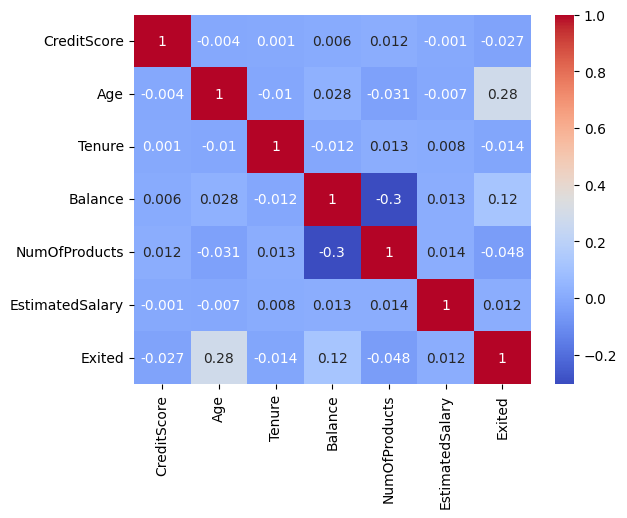

In [ ]:
#feature selection
num_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Exited']

sns.heatmap(data=df[num_cols].corr().round(3), annot=True, cmap='coolwarm')

In [ ]:
#check all with pearson correlation function
pearson_correlation(df,'CreditScore','Exited')
pearson_correlation(df,'Age','Exited')
pearson_correlation(df,'Tenure','Exited')
pearson_correlation(df,'Balance','Exited')
pearson_correlation(df,'NumOfProducts','Exited')
pearson_correlation(df,'EstimatedSalary','Exited')

Correlation Coefficient: -0.0271
P-Value: 0.0067
Tolak H0: Ada hubungan signifikan antara CreditScore dan Exited
Correlation Coefficient: 0.2853
P-Value: 0.0000
Tolak H0: Ada hubungan signifikan antara Age dan Exited
Correlation Coefficient: -0.0140
P-Value: 0.1615
Gagal tolak H0: Tidak ada hubungan signifikan antara Tenure dan Exited
Correlation Coefficient: 0.1185
P-Value: 0.0000
Tolak H0: Ada hubungan signifikan antara Balance dan Exited
Correlation Coefficient: -0.0478
P-Value: 0.0000
Tolak H0: Ada hubungan signifikan antara NumOfProducts dan Exited
Correlation Coefficient: 0.0121
P-Value: 0.2264
Gagal tolak H0: Tidak ada hubungan signifikan antara EstimatedSalary dan Exited


# Visualization

<Axes: xlabel='Geography', ylabel='Churn_rate'>

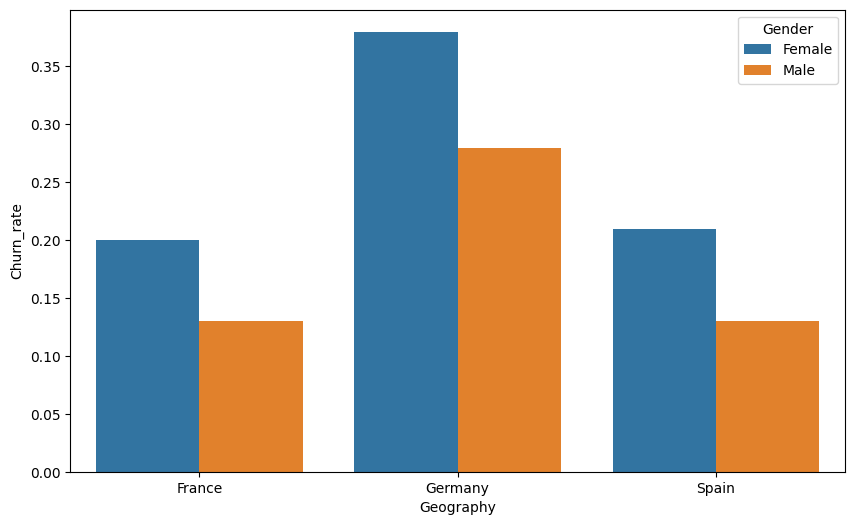

In [ ]:
#ploting summary_1
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_1.reset_index(), x='Geography', y='Churn_rate', hue='Gender')


<Axes: xlabel='Geography', ylabel='count_value'>

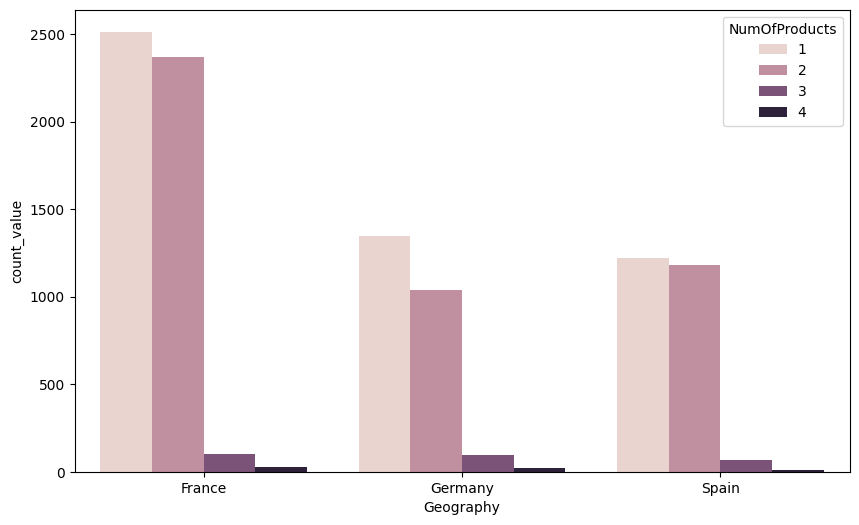

In [ ]:
#ploting summary_2
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_2.reset_index(), x='Geography', y='count_value', hue='NumOfProducts')

<Axes: xlabel='HasCrCard', ylabel='Churn_rate'>

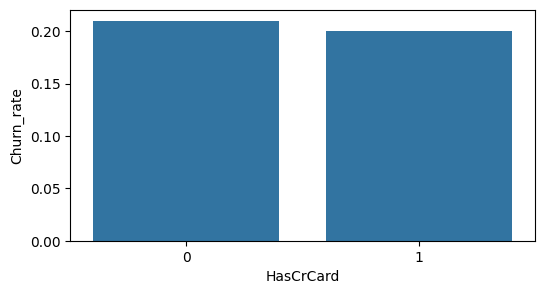

In [ ]:
#ploting summary_3
plt.figure(figsize=(6, 3))
sns.barplot(data=summary_3.reset_index(), x='HasCrCard', y='Churn_rate')

<Axes: xlabel='credit_score_segment', ylabel='Churn_rate'>

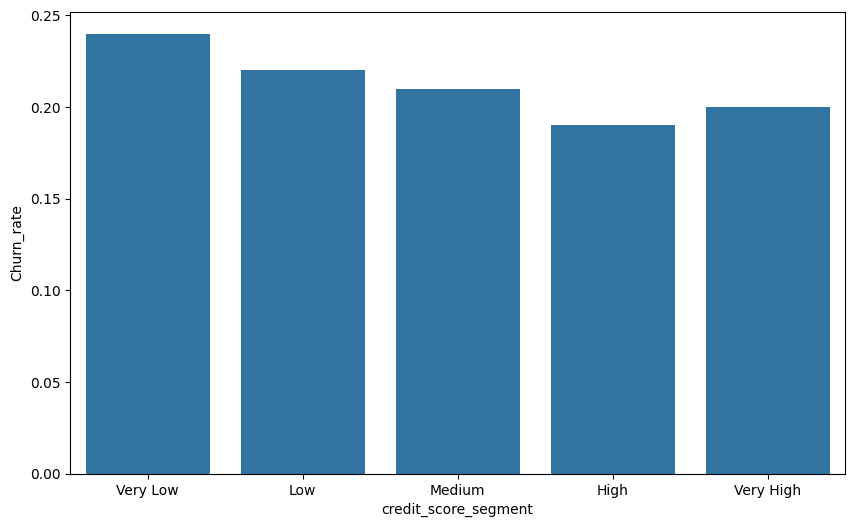

In [ ]:
#ploting summary_5
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_5.reset_index(), x='credit_score_segment', y='Churn_rate')

# Conclusion

## Insight
### Insight for Customer Success
- Gender Female have highest churn rate than Male in every country. already test with A/B test hypothesis . H0 is rejected. so it's true
- customer has credit card or no have same churn rate
- with A/B test it's true no significant mean with tenure customer, every tenure have same exited churn
- Credit score have different churn with A/B test H0 is rejected.
And already segmentation with values(500,550,650,750,750+) labels ('Very Low', 'Low', 'Medium', 'High', 'Very High')


### Insight for Products team
- Highest Churn rate is product num (3 and 4) 90 - 100 % churn
- Product churn have same problem in every country is product num (3 and 4)
- product num (3 and 4) less than other (1 and 2) average between 50 - 100 customer
- already test with A/B test hypothesis. H0 is rejected. so it's true


##Recommended
### Customer success team
- more monitoring definition Female gender because have more highest risk churn. And also more monitoring with
between 500 - 650 credit score, because customer churn risk around that values.
- more monitoring in Germany customer because the highest churn from Germany country

# Products team
- Focus on product 3 and 4 for evaluation or maybe delete products because have similar highest churn risk every country
and also less customer used that product and every country churn rate around 90 - 100% churn






# Load to GCP (BigQuery)